In [1]:
from common import *

Using TensorFlow backend.


# Load data

In [2]:
model = gensim.models.Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = model.wv

2017-08-01 18:53:54,047 : INFO : loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-08-01 18:53:56,112 : INFO : loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-08-01 18:53:56,113 : INFO : loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-08-01 18:53:57,789 : INFO : setting ignored attribute syn0norm to None
2017-08-01 18:53:57,790 : INFO : loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-08-01 18:53:59,394 : INFO : setting ignored attribute cum_table to None
2017-08-01 18:53:59,396 : INFO : loaded ../data/vectors/w2v_model_300_w10


In [3]:
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'pure.dict'))
tfidf = models.TfidfModel.load(join(DATA_FOLDER, 'tfidf_pure.model'))
# !!!!!
tfidf.normalize= True

2017-08-01 18:54:01,219 : INFO : loading Dictionary object from ../data/pure.dict
2017-08-01 18:54:02,609 : INFO : loaded ../data/pure.dict
2017-08-01 18:54:02,610 : INFO : loading TfidfModel object from ../data/tfidf_pure.model
2017-08-01 18:54:03,071 : INFO : loaded ../data/tfidf_pure.model


In [4]:
all_docs = get_all_docs(DATA_FOLDER)
val_docs = sorted(glob(join(DATA_FOLDER, 'validate/*.txt')))

# Main funcs

In [5]:
def sim_matrix(word_set1, word_set2, wv):
    l1 = list(word_set1)
    l2 = list(word_set2)
    wv1 = wv[l1]
    wv2 = wv[l2]
    
    arr = cosine_similarity(wv1, wv2)
    
    smat = pd.DataFrame(arr, index=l1, columns=l2)
    return smat
    

In [6]:
def wmd(smat, tfidf_weights):
    maxs = np.amax(smat, axis=0)
    return np.dot(maxs, tfidf_weights)

In [7]:
def get_test_tfidf_weights(val_docs, wv):
    tweights = {}
    for fname in tqdm(val_docs):
        with open(fname, 'r') as f:
            doc_text = f.read()
        tokenized_filtered = [w for w in tokenize(doc_text) if w in wv]
        doc_bow = dictionary.doc2bow(tokenized_filtered)
        sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
        sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                                   columns=['word', 'score'])
        
        name = path.splitext(basename(fname))[0]
        tweights[name] = sorted_tfidf
            
    return tweights

In [8]:
tweights = get_test_tfidf_weights(val_docs, wv)
val_words = set(pd.concat([v.word for v in tweights.values()]))
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

100%|██████████| 130/130 [00:00<00:00, 173.99it/s]


In [9]:
# tweights['_01_98_2010120931A10010101RU']

In [10]:
def doc_queries_distances(d_smat, tweights):
    dists = []
    for k, query in tweights.items():
        if len(query) == 0:
            dists.append(None)
            continue
        
        qsmat = d_smat.loc[:, query.word]
        dist = wmd(qsmat, query.score)
        dists.append(dist)
    return dists


def _calc(docs):        
    doc_dists = []
    if len(docs) and len(docs[0]) and type(docs[0][0]) == list:
        words = set([w for doc in docs for sent in doc for w in sent if w in wv])
    else:
        words = set([w for doc in docs for w in doc if w in wv])
    smat = sim_matrix(words, val_words, wv)
    for doc in docs:
        if len(doc) and type(doc[0]) == list:
            doc_words = set([w for sent in doc for w in sent])
        else:
            doc_words = set(doc)
        d_smat = smat.loc[doc_words, :]
        dists = doc_queries_distances(d_smat, tweights)

        doc_dists.append(dists)
        
    del smat, d_smat, words
    
    return doc_dists


def calc_dists(fnames, wv):
    doc_dists = []
    for fn in fnames:
        print(fn)
        ! echo {fn} >> ../data/out
        with GzipFile(fn, 'r') as myzip:
            text = myzip.read()
        docs = json.loads(text)
        
        parallelizer = Parallel(n_jobs=cpu_count)

        # this iterator returns the functions to execute for each task
        tasks_iterator = ( delayed(_calc)(docs_block) for 
                          docs_block in grouper(len(docs)//cpu_count, docs) )  
        result = parallelizer( tasks_iterator )        
        doc_dists += result
            
    return np.array(sum(doc_dists, []))

In [128]:
val_dists = calc_dists(ziped_files[:1], wv)

../data//documents/0.json.gz


100%|██████████| 298/298 [01:49<00:00,  4.37it/s]


In [132]:
np.save(join(DATA_FOLDER, 'val_dists.npy'), val_dists)

In [67]:
val_dists = np.load(join(DATA_FOLDER, 'val_dists.npy'))

In [68]:
sorted_args = val_dists.argsort(axis=0)[-20000000:][::-1]

In [63]:
sorted_args = np.load(join(DATA_FOLDER, 'sorted_args_200.npy'))

In [64]:
sorted_args

array([[1022450, 1022450, 1022450, ..., 1022450, 1022450, 1022450],
       [ 291479,  756153, 1036047, ...,  141303,   97013,  446979],
       [ 449466,  183979,  449466, ...,  226883,  449466,  287118],
       ..., 
       [ 510153, 1041255,  526974, ...,  343878,  393105,  136507],
       [ 324196,  228566,  304550, ...,  499947,   16965,  522205],
       [ 164849,  793717,  351308, ...,  260310,  300050,  268891]])

In [86]:
best = {}
for i in range(sorted_args.shape[1]):
    col = sorted_args[:,i]
    name = path.splitext(basename(val_docs[i]))[0]
    top = []
    for j,c in enumerate(col):
        top.append(path.splitext(basename(all_docs[c]))[0])
    best[name] = top

In [84]:
with open(join(DATA_FOLDER, 'gold.json'), 'r') as f:
    gold = json.load(f)

median
acc10     0.0
acc20     0.0
acc200    0.1
dtype: float64
mean
acc10     0.190000
acc20     0.220769
acc200    0.403718
dtype: float64


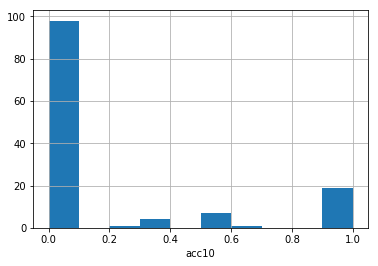

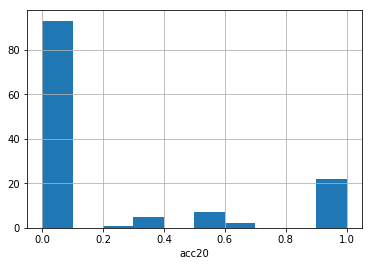

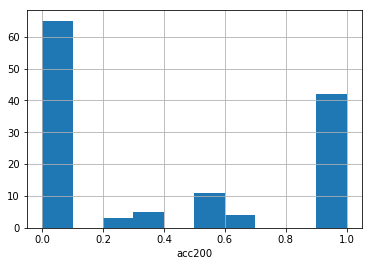

In [87]:
res = evaluate(best, gold)

In [142]:
send_email(notebook_url, body='Finished')

Successfully sent email


TODO:
* normalize = False in tfidf
* first 2-3 sents of query

# Check

In [56]:
!cat {all_docs[3]}

способ регулирование мощность обратный канал  . 
 изобретение относиться к система беспроводный связь .
 технический результат являться регулирование мощность передача по обратный канал для все пользователь в предел соты .
 для этот в первое вариант сначала измерять помеха первое тип ( шаг s600 ) , затем измерять помеха второе тип ( шаг s605 ) , определять отношение между результат первое и второе измерение ( шаг s610 ) и передавать измеренный отношение множество мобильный устройство ( шаг s615 ) .
 во второе вариант принимать передавать отношение , в который указывать отношение между помеха два различный тип ( шаг s650 ) , рассчитывать уровень мощность передача по обратный канал , исходить из передавать отношение , который быть принимать ( шаг s655 ) .
 в третье вариант сначала регулировать мощность передача в режим многостанционный доступ с ортогональный частотный разделение канал ( ofdma ) , исходить из первое сигнал обратный связь во время передача в режим ofdma ( шаг s725 ) , и за

In [39]:
! cat {val_docs[0]}

﻿способ экономия электроэнергия .
 изобретение относиться к проблема экономия электроэнергия , как один из весомый в программа борьба с глобальный потепление климат , и эффективный мочь быть применять , как это ни показаться неожиданный , в область кулинарный хозяйство .
 проблема с электроэнергия возникнуть сразу же после изобретение в 1879 г . гениальный томас альва эдисон электрический лампа накаливание .
 при ее запиток от использовать тогда источник постоянный ток , недопустимый большой быть потеря в линия передача на большой расстояние .
 проблема быть устранять в 1887 г . один из великий физик современность никола теслый , свой изобретение генератор переменный ток и высоковольтный трансформатор .
 дальнейший нововведение , как и этот , подстраиваться , в основной , к электрический характеристика объект запиток , как правило не учитывать они физический особенность .
 в кулинария экономия затрачивать энергия не являться главенствующий фактор , но неизменный оставаться только стрем

In [23]:
val_docs[0]

'../data/validate/_01_98_2010120931A10010101RU.txt'

In [24]:
tweights['_01_98_2010120931A10010101RU']

,word,score
0,показаться,0.440496
1,весомый,0.398666
2,потепление,0.371143
3,климат,0.290792
4,неожиданный,0.246081
5,кулинарный,0.239139
6,возникнуть,0.237528
7,глобальный,0.233594
8,борьба,0.219673
9,экономия,0.197734


In [41]:
# with open(all_docs[0]) as f:
#     text = f.read()
# doc = []
# for sent in nltk.sent_tokenize(text):
#     doc.append(list(tokenize(sent)))

In [57]:
doc = docs[3]
# words = set([w for s in doc for w in s if w in wv])
words = set([w for w in doc if w in wv])

smat = sim_matrix(words, val_words, wv)

query = tweights['_01_98_2010120931A10010101RU']
qsmat = smat.loc[:, query.word]
dist = wmd(qsmat, query.score)
dist


1.1862011812374436

In [58]:
qsmat

,показаться,весомый,потепление,климат,неожиданный,кулинарный,возникнуть,глобальный,борьба,экономия,электроэнергия,хозяйство,программа,проблема,область
предел,0.222915,0.226620,0.129059,0.249751,0.217041,0.089712,0.252470,0.119421,0.061989,0.213100,0.203619,0.133903,0.105193,0.113047,0.266639
пользователь,0.316479,0.186099,0.177385,0.215726,0.191394,0.209686,0.294490,0.328601,0.117957,0.200976,0.238368,0.099609,0.385787,0.340293,0.246072
регулирование,0.145263,0.238717,0.146695,0.266941,0.238457,0.126915,0.202871,0.160395,0.191642,0.315056,0.400921,0.208903,0.171184,0.338859,0.170977
мощность,0.048589,0.223808,0.096208,0.151937,0.052074,0.113107,0.216917,0.147175,0.101564,0.312040,0.460422,0.139996,0.206276,0.187195,0.110190
технический,0.157256,0.365887,0.140045,0.231464,0.358872,0.244606,0.221113,0.116418,0.257968,0.407176,0.301018,0.336685,0.139576,0.422906,0.118049
связь,0.119589,0.172368,0.127367,0.169457,0.156390,0.156906,0.310426,0.335313,0.182458,0.156400,0.272299,0.154010,0.187882,0.271217,0.173028
канал,0.135300,0.134975,0.127520,0.129224,0.029010,0.115552,0.273952,0.180487,0.098440,0.198425,0.231041,0.100958,0.184882,0.194813,0.190089
соты,0.097455,0.157869,0.178990,0.259451,0.125702,0.112175,0.159508,0.317211,0.128234,0.206745,0.166468,0.162317,0.179217,0.204434,0.111233
беспроводный,0.102244,0.087262,0.192080,0.174451,0.102853,0.187479,0.199307,0.517019,0.166504,0.179111,0.304019,0.149040,0.360184,0.233925,0.150488
передача,0.113141,0.156698,0.104309,0.104834,0.049126,0.127363,0.274694,0.302169,0.108817,0.250237,0.300007,0.078564,0.269865,0.218271,0.149493


In [64]:
qsmat['показаться'].argmax()

'пользователь'

In [59]:
maxs = np.amax(qsmat, axis=0)
maxs.sort_values(ascending=False)
# np.dot(maxs, tfidf_weights)

глобальный        0.517019
электроэнергия    0.460422
проблема          0.422906
экономия          0.407176
программа         0.385787
весомый           0.365887
неожиданный       0.358872
хозяйство         0.336685
показаться        0.316479
возникнуть        0.310426
климат            0.266941
область           0.266639
борьба            0.257968
кулинарный        0.244606
потепление        0.192080
dtype: float32

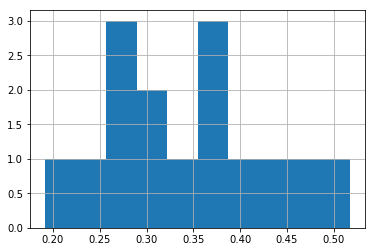

count    15.000000
mean      0.340660
std       0.088724
min       0.192080
25%       0.266790
50%       0.336685
75%       0.396482
max       0.517019
dtype: float64


In [62]:
maxs.hist()
plt.show()
print(maxs.describe())

**Чем больше документ, тем больше вероятность что в нем найдутся близкие слова к запросу**

Как с этим бороться:

* взять первых несколько (top 3) предложений в запросе и документе, взять, так сказать, суть
* привести все документы к одинаковому количеству слов. Можно взять топ 15 слов по tfidf из запроса и документа.
* взять первые 4 предложение и самое первое (название, обычно дублируется), выкинуть
* редкие слова (неучтенные стоп слова), которые не имеют особого значения, могут иметь большой вес tfidf, что обманывает алгоритм. Надо либо убрать как можно больше стоп слов, либо при подсчете расстояния м/у документами не учитывать tfidf вообще
* чтобы исключить стоп слова или другой мусор, можно взять параметр tfidf модели - процент встречи > 50% то считаем шумом
* поиграть с параметрами - для запроса первые 3 предложения, для документа - 3,4,5


# First_n

In [11]:
fn = join(DATA_FOLDER, 'first3_val.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
val_documents = json.loads(text)
del text

In [12]:
tweights = {}
for fname, doc in tqdm(zip(val_docs, val_documents)):
    tokenized_filtered = [w for w in doc if w in wv]
    doc_bow = dictionary.doc2bow(tokenized_filtered)
    sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
    sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                               columns=['word', 'score'])

    name = path.splitext(basename(fname))[0]
    tweights[name] = sorted_tfidf

val_words = set(pd.concat([v.word for v in tweights.values()]))

130it [00:00, 1588.17it/s]


In [13]:
fn = join(DATA_FOLDER, 'first3.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
del text

In [14]:
doc_dists = []

split_on = len(docs)//(cpu_count*100)
for i,sub_docs in enumerate(tqdm(np.array_split(docs, split_on))):
    ! echo {i} >> ../data/out
    parallelizer = Parallel(n_jobs=cpu_count)

    # this iterator returns the functions to execute for each task
    tasks_iterator = ( delayed(_calc)(docs_block) for 
                      docs_block in grouper(100, sub_docs) )  
    result = parallelizer( tasks_iterator )        
    doc_dists += result

# doc_dists = _calc(docs)

val_dists = np.array(sum(doc_dists, []))

100%|██████████| 2/2 [00:14<00:00,  9.13s/it]


In [47]:
val_dists[:,0]

array([ 1.54428693,  1.01526538,  1.16861337,  1.18620118,  0.9272794 ,
        1.15697594,  1.17571529,  1.03664417,  1.18212488,  1.05627956])

In [17]:
sorted_args = val_dists.argsort(axis=0)[-20000000:][::-1]

In [21]:
sorted_args[:,0]

array([0, 3, 8, 6, 2, 5, 9, 7, 1, 4])

In [ ]:
np.save(join(DATA_FOLDER, 'val_dists_first3.npy'), val_dists)

In [120]:
send_email('notebook_url', body='Finished')